# Inverse Participation Ratio

In [1]:
using PyPlot, PyCall
using LinearAlgebra
using SparseArrays
using KrylovKit
using Interpolations
using Cubature, Cuba, MultiQuad

Out task is to compute the nthInverse Participation Ratio (IPR) of our potential $V(\mathbf{r})$, given by
\begin{align*}
\operatorname{IPR}_{n}=\frac{\int \mathrm{d} \mathbf{r}\left|\psi_{n}(\mathbf{r})\right|^{4}}{\left(\int \mathrm{d} \mathbf{r}\left|\psi_{n}(\mathbf{r})\right|^{2}\right)^{2}}.
\end{align*}
In doing this, we have to compute the nth eigenfunction of the Hamiltonian
$$
    \hat{h}=\frac{-\hbar^{2}}{2 m} \nabla^{2}+V(\mathbf{r}, t).
$$
in a box where the wavefunction vanished at the boundary. Here is $n=0$ is the ground state, $n=1$ the first excited state, etc. The meshgrid of the box is computed with the following code:

In [2]:
function meshgrid(x::LinRange{Float64, Int64}, y::LinRange{Float64, Int64})::Tuple{Matrix{Float64}, Matrix{Float64}}
    X = [x for _ in y, x in x]
    Y = [y for y in y, _ in x]
    X, Y
end

meshgrid (generic function with 1 method)

The potential can be every potential we want. We want to concentrate on optical lattices. We define a Quasi- (`QC`) and periodic lattice (`PC`).

In [3]:
function QC(x::Float64, y::Float64, V₀::Float64)::Float64
    return V₀*(cos(pi*x)^2 + cos(pi*√2/2*(x+y))^2 + cos(pi*y)^2 + cos(-pi/(√2)*(x-y))^2)
end
function PC(x::Float64, y::Float64, V₀::Float64)::Float64
    return V₀*(sin(pi*x)^2+sin(pi*y)^2)
end

PC (generic function with 1 method)

The eigenfunctions are computed by using the finite difference method to discretise the Hamiltonian. The eigenvectors are than computed by the Lanczos algorithm via the package `KrylovKit.jl`.

In [4]:
function eigenfunctionDBCKrylov(V::Matrix{Float64}, L::Float64, N::Int64)
    Δx² = (2*L/N)^2
    # creates the discretised 2nd derivative
    D = sparse(Tridiagonal(ones(N-1), -2*ones(N), ones(N-1)))
    # N**2 x N**2 matrix
    T = -1/(Δx²*pi^2) * (kron(D, sparse(I,N,N)) + kron(sparse(I,N,N), D))
    U = spdiagm(reshape(V, N^2))
    H = T + U;

    _, vecs, _ = eigsolve(H, 1, :SR)
    # _, eigenvector = eigs(H, nev=1, which=:SM);

    return reshape(vecs[1]', N, N)
end

eigenfunctionDBCKrylov (generic function with 1 method)

An example would be

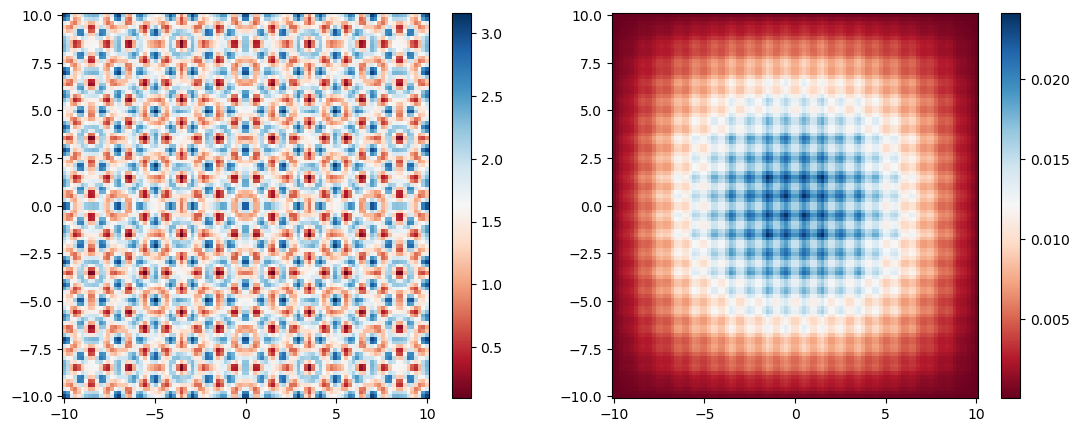

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000A2E2F6D0>

In [6]:
V₀ = 0.8
L = 10.0
N = 100
x, y = LinRange(-L, L, N), LinRange(-L, L, N)
X, Y = meshgrid(x, y);
V = QC.(X, Y, V₀)
ef = eigenfunctionDBCKrylov(V, L, N)

fig, axes = subplots(nrows=1, ncols=2, figsize=(13, 5))
im1 = axes[1].pcolormesh(X, Y, V, cmap=:RdBu)
colorbar(im1, ax=axes[1])
im2 = axes[2].pcolormesh(X, Y, ef^2, cmap=:RdBu)
colorbar(im2, ax=axes[2])

The 0th-IPR is than found by interpolating the computed matrix eigenvectors and numerically computing the integrals.

In [7]:
function inverse_participation_ratio(ef::Matrix{Float64}, L::Float64, N::Int64)
    x = LinRange(-L, L, N)
    y = LinRange(-L, L, N)

    itp_densityprob  = scale(interpolate(ef^2, BSpline(Linear())), x, y)
    itp_densityprob² = scale(interpolate(ef^4, BSpline(Linear())), x, y)

    int_densityprob,  _  = hcubature(v::Vector{Float64} -> itp_densityprob(v[1], v[2]),
                                        [-L, -L],
                                        [L, L]
                                        )
    int_densityprob², _ = hcubature(v::Vector{Float64} -> itp_densityprob²(v[1], v[2]),
                                        [-L, -L],
                                        [L, L]
                                        )
    return int_densityprob²/int_densityprob^2
end

inverse_participation_ratio (generic function with 1 method)

In [12]:
L = 10.0;
Δx² = 0.2;
N = Int64(div(2*L, Δx²))
V₀ =  1.5
x, y = LinRange(-L, L, N), LinRange(-L, L, N)
X, Y = meshgrid(x, y);
V = QC.(X, Y, V₀)

ef = convert(Matrix, eigenfunctionDBCKrylov(V, L, N))
IPR = inverse_participation_ratio(ef, L, N)


0.3070619330284091

## Summary

In [1]:
using PyPlot, PyCall
using LinearAlgebra
using SparseArrays
using KrylovKit
using Interpolations
using Cubature, Cuba, MultiQuad

function QC(x::Float64, y::Float64, V₀::Float64)::Float64
    return V₀*(cos(pi*x)^2 + cos(pi*√2/2*(x+y))^2 + cos(pi*y)^2 + cos(-pi/(√2)*(x-y))^2)
end

function PC(x::Float64, y::Float64, V₀::Float64)::Float64
    return V₀*(sin(pi*x)^2+sin(pi*y)^2)
end

function eigenfunctionDBCKrylov(V::Matrix{Float64}, L::Float64, N::Int64)
    Δx² = (2*L/N)^2
    # creates the discretised 2nd derivative
    D = sparse(Tridiagonal(ones(N-1), -2*ones(N), ones(N-1)))
    # N**2 x N**2 matrix
    T = -1/(Δx²*pi^2) * (kron(D, sparse(I,N,N)) + kron(sparse(I,N,N), D))
    U = spdiagm(reshape(V, N^2))
    H = T + U;

    _, vecs, _ = eigsolve(H, 1,:SR)
    # _, eigenvector = eigs(H, nev=1, which=:SM);

    return reshape(vecs[1]', N, N)
end

function inverse_participation_ratio(ef::Matrix{Float64}, L::Float64, N::Int64)
    x = LinRange(-L, L, N)
    y = LinRange(-L, L, N)

    itp_densityprob  = scale(interpolate(ef^2, BSpline(Linear())), x, y)
    itp_densityprob² = scale(interpolate(ef^4, BSpline(Linear())), x, y)

    int_densityprob,  _  = hcubature(v::Vector{Float64} -> itp_densityprob(v[1], v[2]),
                                        [-L, -L],
                                        [L, L]
                                        )
    int_densityprob², _ = hcubature(v::Vector{Float64} -> itp_densityprob²(v[1], v[2]),
                                        [-L, -L],
                                        [L, L]
                                        )
    return int_densityprob²/int_densityprob^2
end

function meshgrid(x::LinRange{Float64, Int64}, y::LinRange{Float64, Int64})::Tuple{Matrix{Float64}, Matrix{Float64}}
    X = [x for _ in y, x in x]
    Y = [y for y in y, _ in x]
    X, Y
end


L = 50.0;
Δx² = 0.1;
N = Int64(div(2*L, Δx²))
V₀_range = 0.01:0.2:1.5
IPR = Vector{Float64}(undef, length(V₀_range))
Threads.@threads for i in eachindex(V₀_range)
    x, y = LinRange(-L, L, N), LinRange(-L, L, N)
    X, Y = meshgrid(x, y);
    V = QC.(X, Y, V₀_range[i])

    ef = convert(Matrix, eigenfunctionDBCKrylov(V, L, N))
    IPR[i] = inverse_participation_ratio(ef, L, N)
end
plot(V₀_range, IPR)